In [35]:
import pandas as pd
import numpy as np
import sys
%load_ext rpy2.ipython
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
sys.path.append('../../')
from src.utils import load_splits

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.42 ms (started: 2022-02-21 14:33:19 -08:00)


In [7]:
conditional_wfst = pd.read_table('../../output/fst/chi_conditioned_fst.csv', sep='\t', 
header=None, skipfooter=1)

/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


In [12]:
conditional_wfst
conditional_wfst.columns = ['from','to','input_symbol','output_symbol','surprisal']
conditional_wfst

,from,to,input_symbol,output_symbol,surprisal
0,0,0,0,3,3.805074
1,0,0,0,5,0.330159
2,0,0,0,14,4.703895
3,0,0,0,13,5.861696
4,0,0,0,12,3.419137
...,...,...,...,...,...
351,0,0,42,9,4.274853
352,0,0,42,23,7.410347
353,0,0,42,31,7.410347
354,0,0,42,35,7.410347


In [16]:
superset_chi_sym = pd.read_table('../../output/fst/superset_chi.sym', sep='\t', 
header=None)
superset_chi_sym.columns = ['symbol', 'int']
int_to_symbol = dict(zip(superset_chi_sym['int'], superset_chi_sym['symbol']))


In [17]:
conditional_wfst['input_symbol'] =  [int_to_symbol[x] for x in conditional_wfst['input_symbol']]
conditional_wfst['output_symbol'] =  [int_to_symbol[x] for x in conditional_wfst['output_symbol']]

In [28]:
conditional_wfst['probability'] = np.exp(-1 * conditional_wfst['surprisal'])

time: 7.13 ms (started: 2022-02-21 14:26:53 -08:00)


In [29]:
conditional_wfst

,from,to,input_symbol,output_symbol,surprisal,probability
0,0,0,<epsilon>,t,3.805074,0.022258
1,0,0,<epsilon>,ə,0.330159,0.718809
2,0,0,<epsilon>,ɜ,4.703895,0.009060
3,0,0,<epsilon>,k,5.861696,0.002846
4,0,0,<epsilon>,i,3.419137,0.032741
...,...,...,...,...,...,...
351,0,0,ʤ,ɡ,4.274853,0.013914
352,0,0,ʤ,ŋ,7.410347,0.000605
353,0,0,ʤ,a,7.410347,0.000605
354,0,0,ʤ,ɾ,7.410347,0.000605


time: 21.9 ms (started: 2022-02-21 14:26:56 -08:00)


# Filter to commonly-seen phonemes

In [56]:
phono_data = load_splits.load_phono()
phones = pd.DataFrame({'phoneme':  list(' '.join(phono_data.dropna(subset=['actual_phonology_no_dia']).actual_phonology_no_dia))})

time: 11.4 s (started: 2022-02-21 14:42:35 -08:00)


In [71]:
phones['one'] = 1
phones = phones.loc[phones.phoneme != ' ']
phoneme_counts = phones.groupby(['phoneme']).one.agg(np.sum).reset_index()
phoneme_counts.sort_values(by='one', ascending =False)

phonemes_to_keep = phoneme_counts.loc[phoneme_counts.one > 25].phoneme.to_list() + ['<epsilon>'] 


time: 184 ms (started: 2022-02-21 14:47:55 -08:00)


In [72]:
phonemes_to_keep

['a',
 'b',
 'd',
 'e',
 'f',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 's',
 't',
 'u',
 'v',
 'w',
 'z',
 'æ',
 'ð',
 'ŋ',
 'ɑ',
 'ə',
 'ɛ',
 'ɜ',
 'ɡ',
 'ɹ',
 'ɾ',
 'ʃ',
 'ʊ',
 'ʒ',
 'ʔ',
 'θ',
 '<epsilon>']

time: 3.87 ms (started: 2022-02-21 14:47:56 -08:00)


In [75]:
short_conditional_wfst = conditional_wfst.loc[(conditional_wfst.input_symbol.isin(phonemes_to_keep))
& (conditional_wfst.output_symbol.isin(phonemes_to_keep))]

time: 3.24 ms (started: 2022-02-21 14:48:12 -08:00)


In [76]:
# try moving it to R
%R -i short_conditional_wfst

time: 53.1 ms (started: 2022-02-21 14:48:14 -08:00)


In [118]:
%%R
short_conditional_wfst$input_symbol = gsub('<epsilon>','<ε>',short_conditional_wfst$input_symbol)
short_conditional_wfst$output_symbol = gsub('<epsilon>','<ε>',short_conditional_wfst$output_symbol)

time: 9.49 ms (started: 2022-02-21 15:28:45 -08:00)


In [119]:
%%R
alphabet = sort(unique(short_conditional_wfst$input_symbol))

time: 8.03 ms (started: 2022-02-21 15:28:45 -08:00)


In [120]:
%%R 
#make a dummy heat map of probability 0 to map below
full_grid = expand.grid(alphabet, alphabet)
names(full_grid) = c('input_symbol', 'output_symbol')
full_grid$probability = 0 

for (i in c(1:nrow(short_conditional_wfst))){
    
    row = short_conditional_wfst[i,]
    full_grid[full_grid$input_symbol == row$input_symbol &
             full_grid$output_symbol == row$output_symbol, 'probability'] = row$probability
    
}    
full_grid = full_grid[order(full_grid$input_symbol, full_grid$output_symbol),]


time: 101 ms (started: 2022-02-21 15:28:46 -08:00)


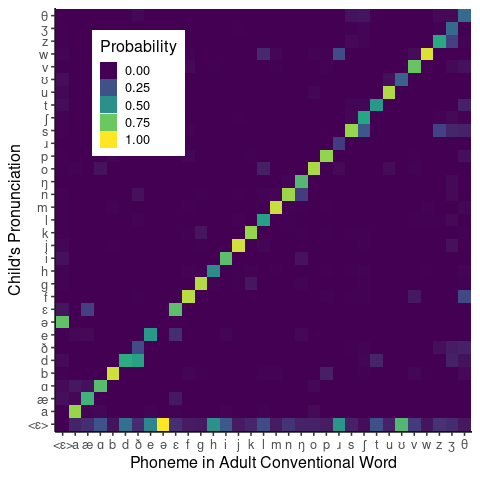

time: 614 ms (started: 2022-02-21 17:01:20 -08:00)


In [146]:
%%R
library('viridisLite')

p1 = ggplot() + geom_tile(
data = full_grid, aes(x=input_symbol, y=as.factor(output_symbol), fill=probability
)) +  scale_fill_viridis_c(na.value=0) + xlab('Phoneme in Adult Conventional Word'
) + ylab("Child's Pronunciation") + theme_classic(base_size=16) +
  guides(fill = guide_legend(title = "Probability")) + theme(legend.position = c(.2, .8))  

ggsave('../../output/figures/fst_prob_matrix.png', width=6, height=6)
print(p1)